In [2]:
%autosave 10
import numpy as np
import tensorflow as tf
from collections import deque
import functools
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools
import pickle 
import matplotlib.pyplot as plt
import pandas
import scipy
import os
import gc


%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

image_width = 28

def display(image):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
def memoize(obj, maxlen = 2000):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]
        
    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

@memoize
def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
#         print image.shape
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split


        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
#         print left_slice.shape
#         print right_slice.shape
        
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

#         plt.imshow(result)
#         plt.show()
#         display(result)

        return result
    else: # four way split
#         print "four way"
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
#         display(result)
        return result

        

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1



file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"


def get_batch(batch_size = 100, random = True, start_index = 0, val = False):
    metamat = np.zeros([batch_size, image_width, image_width, 1]).astype(np.float32)
    regression_y = np.zeros([batch_size,1]).astype(np.float32)
    categorical_y = np.zeros([batch_size]).astype(np.int32)
    extra_features = np.zeros([batch_size,len(wind_data[0])]).astype(np.float32)
    i = 0
    for _ in range(batch_size):

        index = i + start_index
        if random:
            index = rand.randint(0, len(meta)-1)
            if index % 100 == 0 and not val:
                index +=  rand.randint(1, 99)
                if index > len(meta):
                    index = len(meta) -1
            elif val:
                index -= index % 100
        index %= len(meta)
        lon = [meta['lon'][index]]
        lat = [meta['lat'][index]]
        max_wind_speed = np.max(wind_data[index])
        regression_y[i] = y_gaussian[index]
        categorical_y[i] = y_data['y'][index]
        extra_features[i] = wind_data[index]

        xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
        housex=xx[0]
        housey=yy[0]

        lidar = None
        try:
            lidar = get_heightmap_around(housex, housey, window_width_pixels=image_width)
        except:
            continue
        if(lidar == None):
            continue
        
        lidar = lidar.copy()
        lidar[lidar < -100] = -100
        lidar[lidar >250] = 250
#         lidar /= 250.0
#         lidar[lidar > 1000] = 200  # get rid of wierd huge values

        lidar -= np.min(lidar)
        lidar[lidar > 100] = 100
        if np.max(lidar) != 0:
            lidar /= 100# np.max(lidar)
#         lidar /= 200.0


        metamat[i, :, :, 0] = lidar

#         wind_data_channel = np.zeros([image_width, image_width]).astype(np.float32)
#         wind_data_channel.fill(max_wind_speed)
#         metamat[i, :, :, 1] = wind_data_channel



        i += 1

    #metamat = metamat.reshape([batch_size, image_width**2])
#     assert np.max(metamat) < 10
    return metamat, extra_features, regression_y, np.eye(2)[categorical_y]





def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    df = df.sort(['hcad']).fillna(0)
    df = df.reset_index()#(ascending=True)

    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        if normalize_columns and  label != 'hcad':
            column_data = np.array(df[label].astype(np.float32))
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        else:
            data_dict[label] = df[label].astype(np.float)

        result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)
    return result


# metamat_test = get_batch(500)[0]
# plt.hist(metamat_test.flatten(), bins = 100)
# plt.show()


Autosaving every 10 seconds
loaded all file header attributes into dict


In [3]:

wind_data = load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd", 
              normalize_columns=True, only_columns_containing = "spd")
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
hcad_dpr = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd", 
              normalize_columns=True, only_columns_containing = "mean_dpr")
wind_data = np.concatenate((wind_data, hcad_dpr), axis = 1)
# wind_data = wind_data[meta['img0'] == 1]
# y_data = wind_data[meta['img0'] == 1]
y_gaussian = pickle.load(open( "/home/isaac/Desktop/house_guassian_damage_balance.p", "rb" ) )

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum


loading...
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd in read-only mode


In [4]:
get_batch(10)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:218: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(array([[[[ 0.41308594],
          [ 0.25683594],
          [ 0.35253906],
          ..., 
          [ 0.01937866],
          [ 0.015625  ],
          [ 0.01499939]],
 
         [[ 0.33813477],
          [ 0.25634766],
          [ 0.16564941],
          ..., 
          [ 0.03561401],
          [ 0.015625  ],
          [ 0.01625061]],
 
         [[ 0.28198242],
          [ 0.1394043 ],
          [ 0.13317871],
          ..., 
          [ 0.01312256],
          [ 0.01437378],
          [ 0.01499939]],
 
         ..., 
         [[ 0.16064453],
          [ 0.04501343],
          [ 0.04626465],
          ..., 
          [ 0.16308594],
          [ 0.01000214],
          [ 0.01125336]],
 
         [[ 0.10498047],
          [ 0.07440186],
          [ 0.04562378],
          ..., 
          [ 0.09002686],
          [ 0.00937653],
          [ 0.01125336]],
 
         [[ 0.06561279],
          [ 0.09625244],
          [ 0.04937744],
          ..., 
          [ 0.01750183],
          [ 0.00937653],

In [5]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/g3doc/tutorials/mnist/input_data.py
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
n_samples = 800000
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

Based on this, we define now a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

In [7]:
import tflearn
import math

bottom_conv_weights = None

class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, image_width, image_width, 1])
        self.y = tf.placeholder(tf.float32, [None, 10])

        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
#         network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = self._recognition_network()

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
#         z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self._generator_network()
            

            
    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        n_z = self.network_architecture["n_z"]
        m = tflearn.layers.conv.conv_2d(self.x, 32, 3, activation='relu')
        global bottom_conv_weights
        bottom_conv_weights = m.W
        m = tflearn.layers.conv.conv_2d(m, 32, 3, activation='relu')
        m = tflearn.layers.conv.conv_2d(m, 32, 3, activation='relu')

        m = tflearn.layers.conv.max_pool_2d(m, 2)
        m = tflearn.layers.conv.conv_2d(m, 32, 3, activation='relu')
        m = tflearn.layers.conv.conv_2d(m, 32, 3, activation='relu')
        m = tflearn.layers.conv.conv_2d(m, 32, 3, activation='relu')

        m = tflearn.layers.conv.max_pool_2d(m, 2)
        print ("FC input size", m.get_shape())
        z_hidden = tflearn.layers.core.fully_connected(m, n_z, activation='elu')

        z_hidden = tflearn.layers.merge_ops.merge ([z_hidden,self.y], 'concat', axis=1, name='concat')
        z_hidden = tflearn.layers.core.fully_connected(z_hidden, n_z+10, activation='elu')
        z_hidden = tflearn.layers.core.fully_connected(z_hidden, n_z+10, activation='elu')

        z_mean = tflearn.layers.core.fully_connected(z_hidden, n_z, activation='elu')
        z_mean = tflearn.layers.core.fully_connected(z_mean, n_z, activation='linear')
        z_log_sigma_sq = tflearn.layers.core.fully_connected(z_hidden, n_z, activation='elu')
        z_log_sigma_sq = tflearn.layers.core.fully_connected(z_log_sigma_sq, n_z, activation='linear')


        return (z_mean, z_log_sigma_sq)

    def _generator_network(self):
        n_z = self.network_architecture["n_z"]
        z_var = self.z

        z_var = tflearn.layers.merge([z_var, self.y], "concat")
        z_var = tflearn.layers.core.fully_connected(z_var, n_z+10, activation='elu')
        z_var = tflearn.layers.core.fully_connected(z_var, n_z+10, activation='elu')

        # predicting the label
#         label_pred_hidden = tflearn.layers.core.fully_connected(z_var, n_z, activation='elu')
#         label_pred_hidden = tflearn.layers.core.fully_connected(z_var, 10, activation='elu')
#         self.label_prediction = tflearn.layers.core.fully_connected(label_pred_hidden, 10, activation='softmax')



        activation_width = image_width/4
        activation_depth = 32
        print "activation depth", activation_depth

        m = tflearn.layers.core.fully_connected(z_var, 
                                                activation_depth*activation_width**2, activation='relu')
        print "fully connected", m.get_shape()
        m = tf.reshape(m,[-1,activation_width,activation_width,activation_depth])
        print "reshaped", m.get_shape()
#         m = tflearn.conv_2d_transpose(m, 32, 5, [image_width/8, image_width/8, 32], strides=1, activation='relu')
#         m = tflearn.layers.conv.upsample_2d (m, 2)
        m = tflearn.conv_2d_transpose(m, 32, 5, [image_width/4, image_width/4, 32], strides=1, activation='relu')
        m = tflearn.layers.conv.upsample_2d (m, 2)

        m = tflearn.conv_2d_transpose(m, 32, 5, [image_width/2, image_width/2, 32], strides=1, activation='relu')
        print m.get_shape()

        m = tflearn.conv_2d_transpose(m, 32, 5, [image_width/2, image_width/2, 32], strides=1, activation='relu')
        print m.get_shape()

        m = tflearn.layers.conv.upsample_2d (m, 2)
        print m.get_shape()
        m = tflearn.conv_2d_transpose(m, 10, 5, [image_width, image_width, 10], strides=1, activation='relu')
        print m.get_shape()
        m = tflearn.conv_2d_transpose(m, 1, 5, [image_width, image_width, 1], strides=1, activation='sigmoid')
        print m.get_shape()
        x_reconstr_mean = tf.reshape(m,[-1,image_width**2])

#         x_reconstr_mean = tflearn.layers.core.fully_connected(m, image_width**2, activation='sigmoid')
        return x_reconstr_mean


    
    def _create_loss_optimizer(self):
        n_z = self.network_architecture["n_z"]

        
        x_flat = tf.reshape(self.x,[-1,image_width**2])
        
        self.reconstr_loss = \
            -tf.reduce_mean(x_flat * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-x_flat) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)

        self.latent_loss = -0.5 * tf.reduce_mean(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(3*self.reconstr_loss + self.latent_loss)   # average over batch
#         self.cost = tf.reduce_mean(reconstr_loss)
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
        with tf.variable_scope("latent_predictor"):
            dist_true = tf.contrib.distributions.MultivariateNormalDiag(self.z_mean, 
                                                    tf.exp(tf.sqrt(self.z_log_sigma_sq)))
            dist_pred = tflearn.layers.fully_connected(self.y, n_z*2, activation = "elu")
            dist_pred = tflearn.layers.fully_connected(dist_pred, n_z*2, activation = "elu")
            dist_pred = tflearn.layers.fully_connected(dist_pred, n_z*2, activation = "elu")
            self.z_mean_pred = tflearn.layers.fully_connected(dist_pred, n_z, activation="tanh")
            self.z_log_sig_sq_pred = tflearn.layers.fully_connected(dist_pred, n_z, activation="tanh")*20

            dist_true = tf.contrib.distributions.MultivariateNormalDiag(self.z_mean_pred, 
                                                    tf.exp(tf.sqrt(self.z_log_sig_sq_pred)))
        
        # see notebook pg 3 for math
        s0=tf.sqrt(tf.exp(self.z_log_sigma_sq))
        s1=tf.sqrt(tf.exp(self.z_log_sig_sq_pred))
        self.s0=s0
        self.s1=s1
        m0=self.z_mean
        m1=self.z_mean_pred
        
        def dot(a,b):
            return tf.reduce_sum(tf.mul(a,b))
        
        self.latent_pred_loss = .5 * (dot(s0,s1) +  dot(tf.mul(1/(s1+.000000001),(m1-m0)),m1-m0) 
                                      - n_z + tf.log(dot(s1,s1)/(dot(s0,s0)+.000000001)))

        latent_prediction_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='latent_predictor')

        
        self.latent_pred_optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate)\
                .minimize(self.latent_pred_loss,var_list = latent_prediction_variables)
        
    def partial_fit(self, X, Y):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X, self.y:Y})
        return cost
    
    def transform(self, X, Y):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y:Y})
    
    def get_distributions(self, X, Y):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        mu, log_sigma_sq = self.sess.run([self.z_mean, self.z_log_sigma_sq], feed_dict={self.x: X})
        return mu, np.sqrt(np.exp(log_sigma_sq))
    
    def generate(self, z_mu, Y):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.array([np.random.normal(size=self.network_architecture["n_z"])]*self.batch_size)
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu, self.y:Y})
    
    def reconstruct(self, X, Y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X, self.y: Y})

hdf5 not supported (please install/reinstall h5py)


In [8]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(1000):#range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
#             print ("need a batch")

#             batch_xs = get_batch(batch_size)[0]
#             print ("got a batch")
            batch_xs = batch_xs.reshape([-1, image_width, image_width, 1])

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost)
    return vae

In [9]:
tf.reset_default_graph()
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=image_width**2, # MNIST data input (img shape: image_width*image_width)
         n_z=120)  # dimensionality of latent space

# vae = train(network_architecture, training_epochs=30)

display_step=5
vae = VariationalAutoencoder(network_architecture, 
                             learning_rate=.001, 
                             batch_size=100)
# Training cycle
loss_record = []

('FC input size', TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(32)]))
activation depth 32
fully connected (100, 1568)
reshaped (100, 7, 7, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 28, 28, 32)
(?, 28, 28, 10)
(?, 28, 28, 1)
Instructions for updating:
Use `tf.global_variables_initializer` instead.


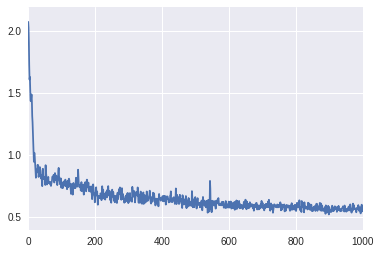

Epoch: 0001 cost= 0.082583155


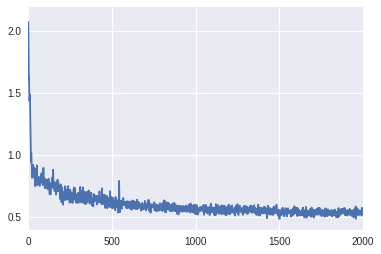

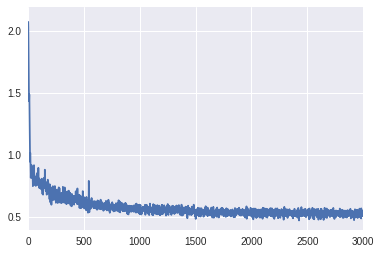

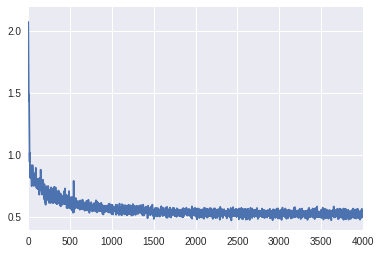

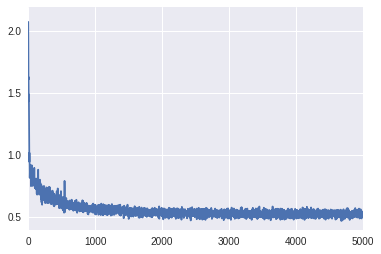

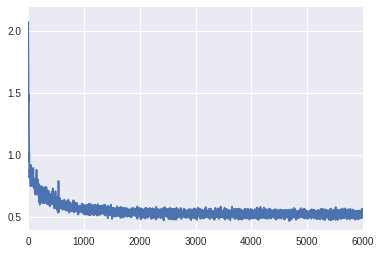

Epoch: 0006 cost= 0.065482657


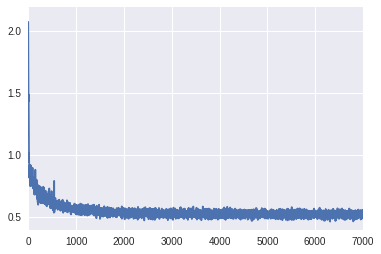

KeyboardInterrupt: 

In [10]:
training_epochs=100
batch_size = 100
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=1000, readout = True)
display(f)
import time
t0 = time.time()

for epoch in range(10):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
#     gen, label_pred = vae.sess.run([vae.x_reconstr_mean, vae.label_prediction], feed_dict = {vae.x:batch_xs, vae.y:batch_ys})

    for i in range(1000):#range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        batch_xs = batch_xs.reshape([-1, image_width, image_width, 1])
        f.value = i

        cost = vae.partial_fit(batch_xs, batch_ys)
        assert(str(cost) != "nan")
        loss_record.append(cost)
        avg_cost += cost / n_samples * batch_size
    plt.plot(loss_record[:])
    plt.show()
    # Display logs per epoch step
    if epoch % display_step == 0:
        print "Epoch:", '%04d' % (epoch+1), \
              "cost=", "{:.9f}".format(avg_cost)

t1 = time.time()
total_time = t1-t0
print total_time

In [11]:
batch_xs, batch_ys = mnist.train.next_batch(batch_size)
batch_xs = batch_xs.reshape([-1, image_width, image_width, 1])
# record = []
from ipywidgets import FloatProgress
from IPython.display import display
num_batches = 1500
f = FloatProgress(min=0, max=num_batches, readout = True)
display(f)

# for i in range(num_batches):
#     f.value = i
#     batch_xs, batch_ys = mnist.train.next_batch(batch_size)
#     batch_xs = batch_xs.reshape([-1, image_width, image_width, 1])
#     record.append(vae.sess.run([vae.latent_pred_loss, vae.latent_pred_optimizer],
#                                       feed_dict = {vae.x:batch_xs, vae.y:batch_ys})[0])
plt.plot(record)
plt.show()

z_mu_three_tensor = np.reshape(np.array([z_mu_three]*batch_size),[100,12])
z_sigma_three_tensor = np.reshape(np.array([z_sigma_three]*batch_size),[100,12])

print z_three_tensor.shape

m,s, m_, s_, gen_correct = vae.sess.run([vae.z_mean_pred, vae.z_log_sig_sq_pred, vae.z_mean, vae.z_log_sigma_sq, vae.x_reconstr_mean],
                                      feed_dict = {vae.x:batch_xs, vae.y:batch_ys})
image = vae.sess.run(vae.x_reconstr_mean,
                                      feed_dict = {vae.x:batch_xs, vae.y:batch_ys,
                                                  vae.z_mean:z_three_tensor, vae.z_log_sigma_sq:z_sigma_three_tensor})
plt.scatter(m,m_)
plt.show()
plt.scatter(s, s_)
plt.show()
plt.hist(s)
plt.show()
# print m
# print s
# print image.shape
for i in range(6):
    print batch_ys[i]
    print np.argmax(batch_ys[i])
    plt.imshow(np.reshape(-gen_correct[i], [image_width,image_width]))
    plt.show()
    plt.imshow(np.reshape(-image[i], [image_width,image_width]))
    plt.show()
    plt.imshow(np.reshape(-batch_xs[i], [image_width,image_width]))
    plt.show()
    print("-"*15)


NameError: name 'record' is not defined

pixel mean 0.131087
0


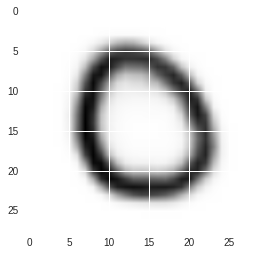

pixel mean 0.124475
0


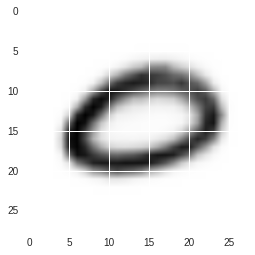

pixel mean 0.136342
0


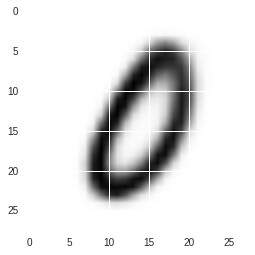

pixel mean 0.124425
0


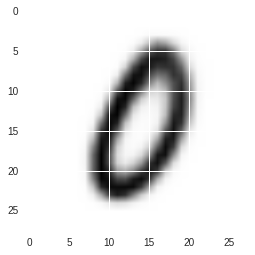

pixel mean 0.135871
0


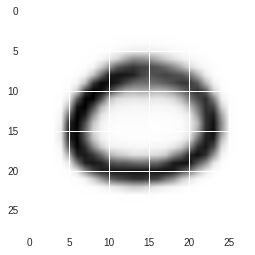

pixel mean 0.132809
0


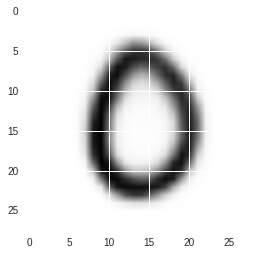

pixel mean 0.127246
0


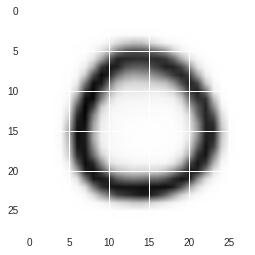

pixel mean 0.126895
0


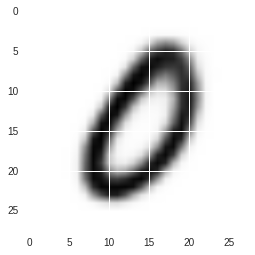

pixel mean 0.130261
0


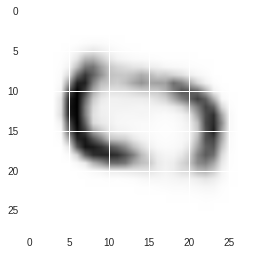

pixel mean 0.128755
0


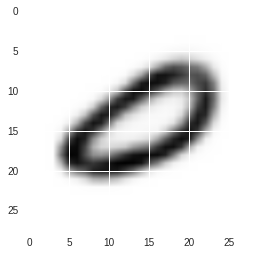

pixel mean 0.134478
1


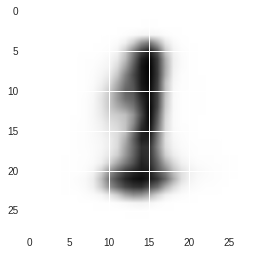

pixel mean 0.123248
1


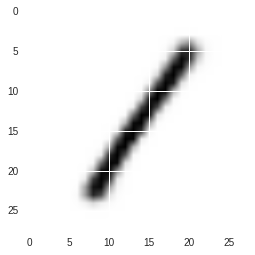

pixel mean 0.130977
1


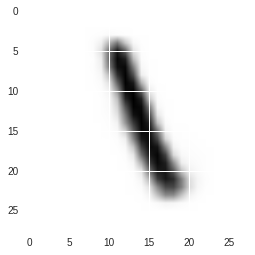

pixel mean 0.129115
1


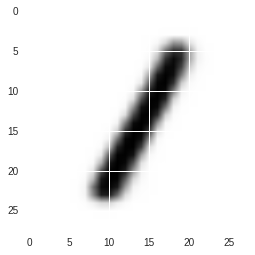

pixel mean 0.134599
1


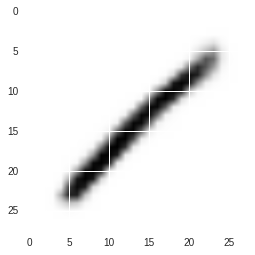

pixel mean 0.120131
1


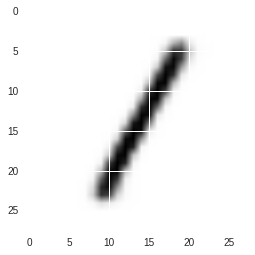

pixel mean 0.127106
1


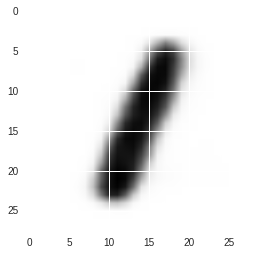

pixel mean 0.130139
1


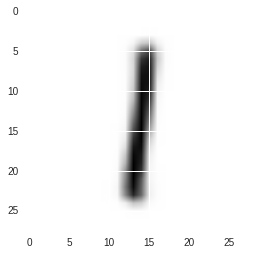

pixel mean 0.1311
1


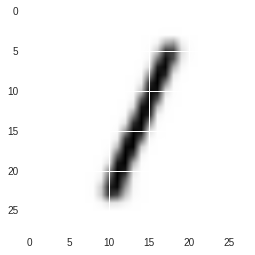

pixel mean 0.130322
1


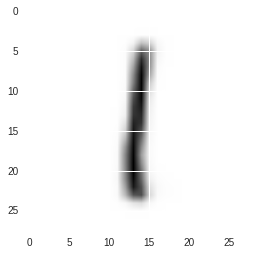

pixel mean 0.124763
2


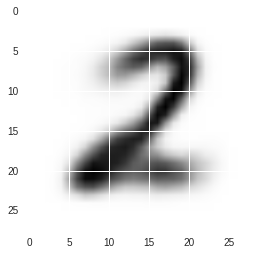

pixel mean 0.134217
2


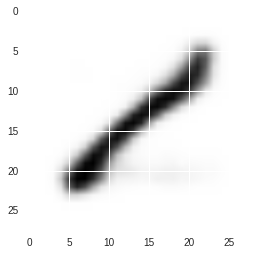

pixel mean 0.127116
2


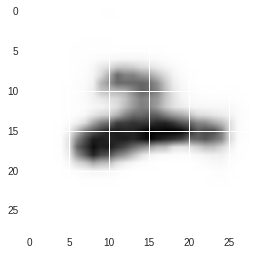

pixel mean 0.130546
2


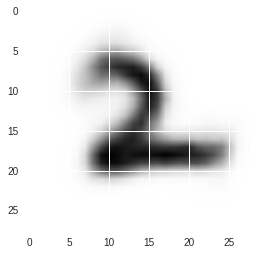

pixel mean 0.136354
2


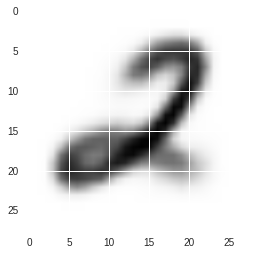

pixel mean 0.12261
2


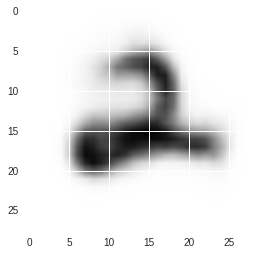

pixel mean 0.13571
2


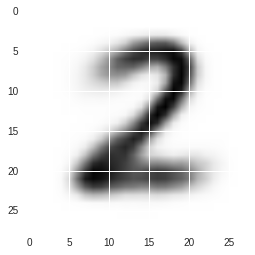

pixel mean 0.13464
2


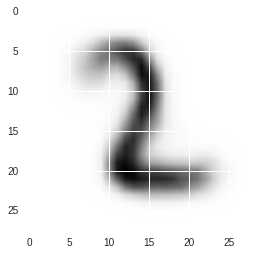

pixel mean 0.126016
2


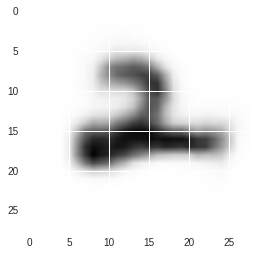

pixel mean 0.121184
2


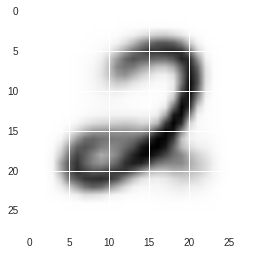

pixel mean 0.122517
3


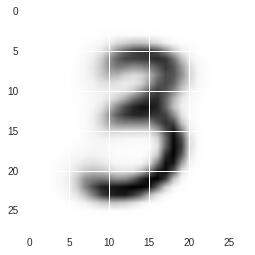

pixel mean 0.131058
3


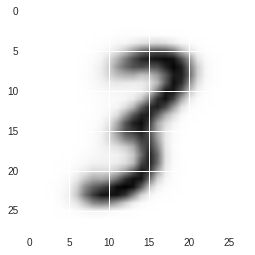

pixel mean 0.127649
3


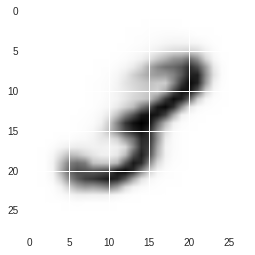

pixel mean 0.139195
3


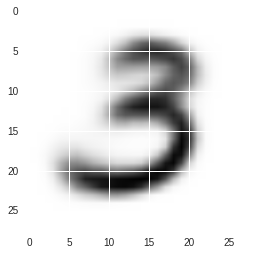

pixel mean 0.127344
3


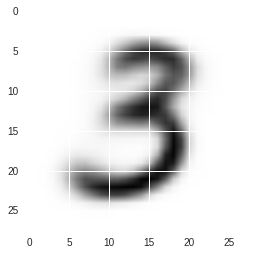

pixel mean 0.132927
3


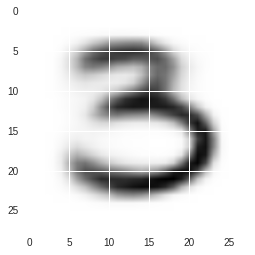

pixel mean 0.122109
3


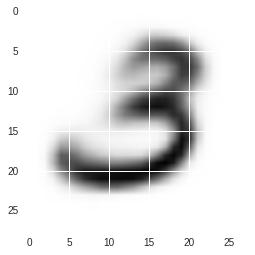

pixel mean 0.131401
3


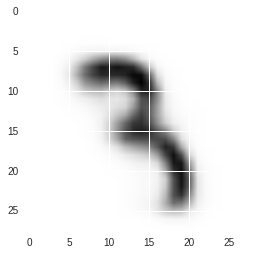

pixel mean 0.132722
3


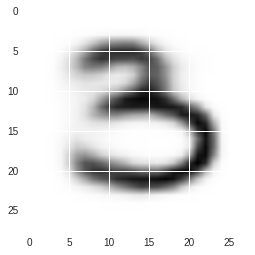

pixel mean 0.133614
3


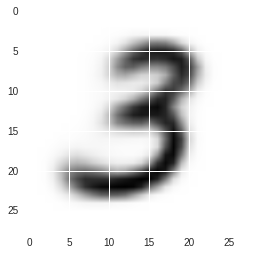

pixel mean 0.136636
4


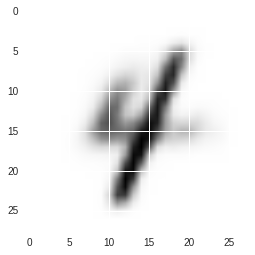

pixel mean 0.126481
4


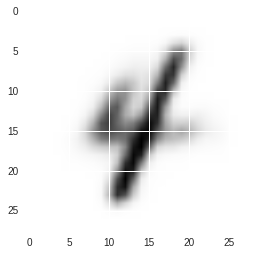

pixel mean 0.128192
4


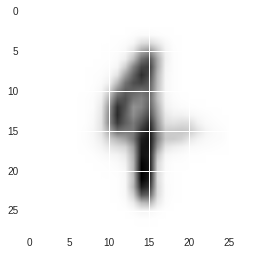

pixel mean 0.130335
4


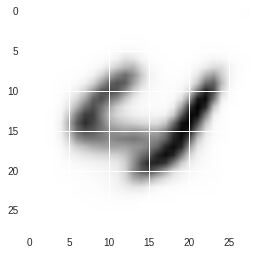

pixel mean 0.126863
4


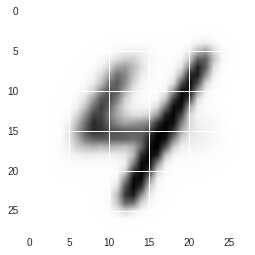

pixel mean 0.122041
4


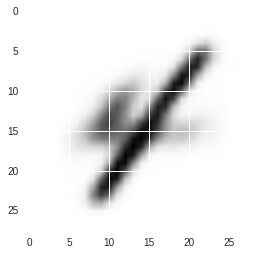

pixel mean 0.131091
4


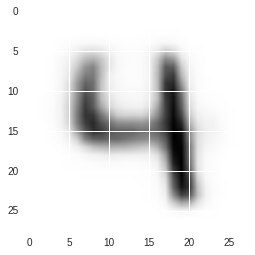

pixel mean 0.133316
4


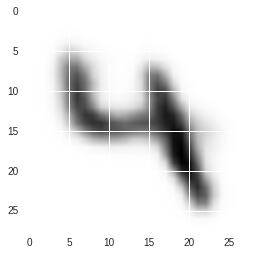

pixel mean 0.126019
4


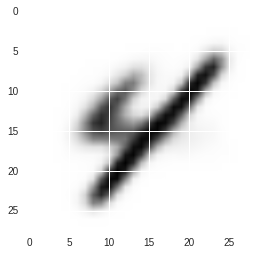

pixel mean 0.137301
4


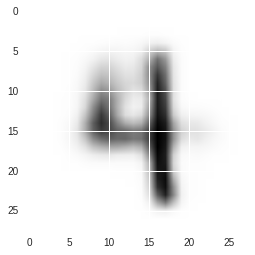

pixel mean 0.131927
5


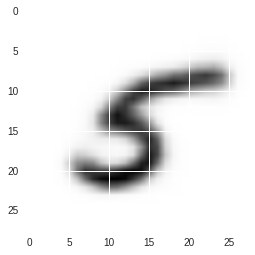

pixel mean 0.130088
5


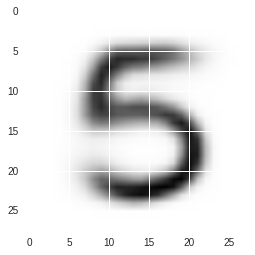

pixel mean 0.12468
5


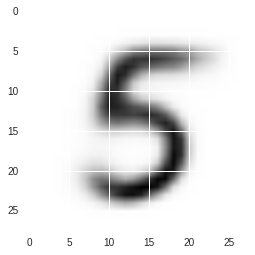

pixel mean 0.127918
5


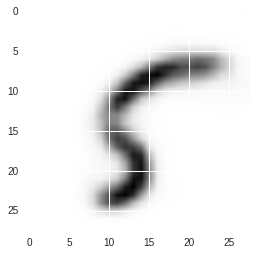

pixel mean 0.127607
5


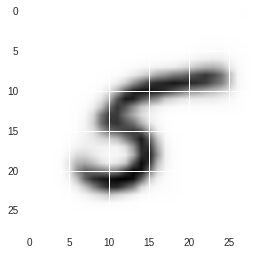

pixel mean 0.125398
5


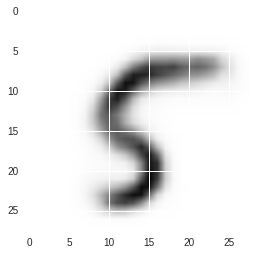

pixel mean 0.125567
5


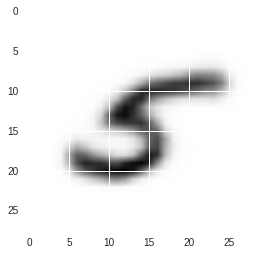

pixel mean 0.13175
5


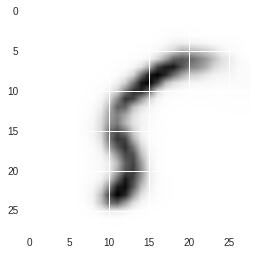

pixel mean 0.122423
5


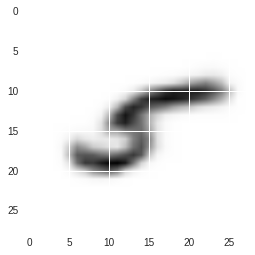

pixel mean 0.137578
5


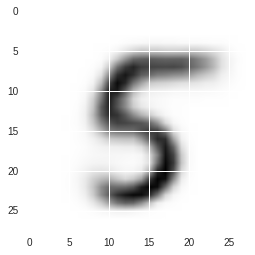

pixel mean 0.125227
6


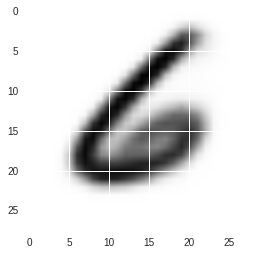

pixel mean 0.130615
6


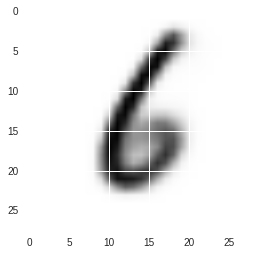

pixel mean 0.133482
6


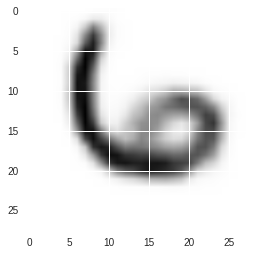

pixel mean 0.134357
6


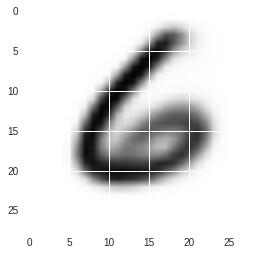

pixel mean 0.122912
6


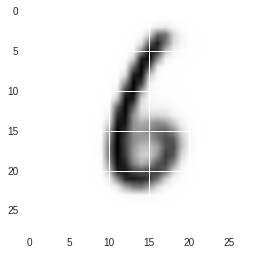

pixel mean 0.133782
6


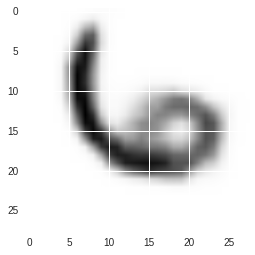

pixel mean 0.136109
6


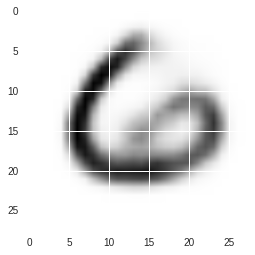

pixel mean 0.128738
6


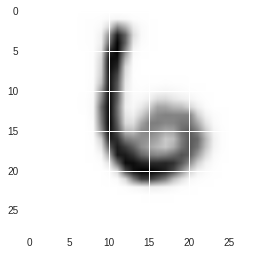

pixel mean 0.139875
6


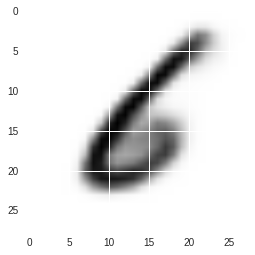

pixel mean 0.129678
6


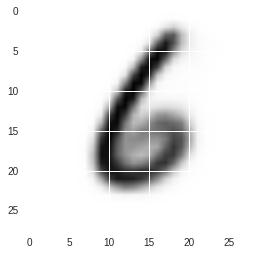

pixel mean 0.130142
7


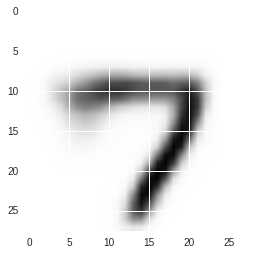

pixel mean 0.123907
7


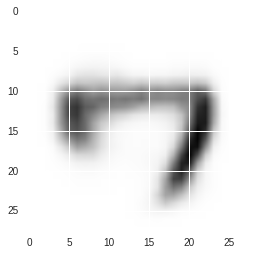

pixel mean 0.128271
7


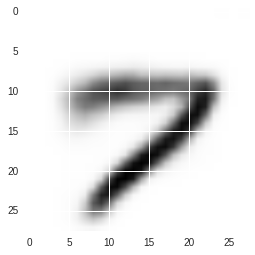

pixel mean 0.13603
7


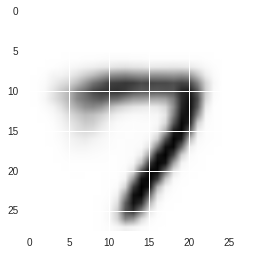

pixel mean 0.131483
7


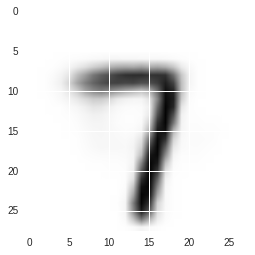

pixel mean 0.127449
7


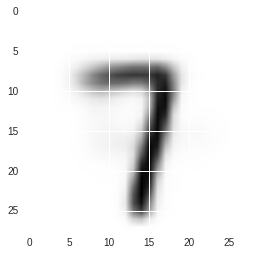

pixel mean 0.132595
7


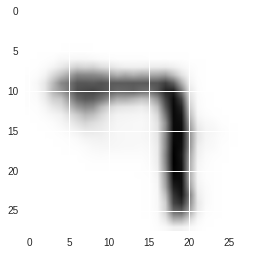

pixel mean 0.125222
7


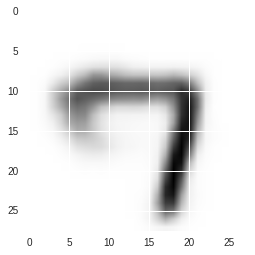

pixel mean 0.131109
7


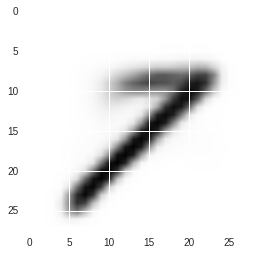

pixel mean 0.129356
7


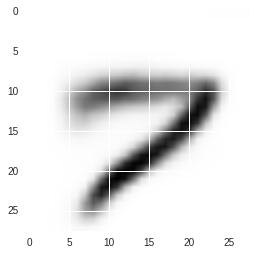

pixel mean 0.138103
8


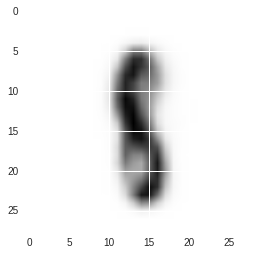

pixel mean 0.12782
8


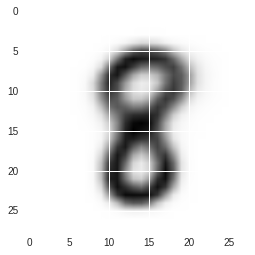

pixel mean 0.125875
8


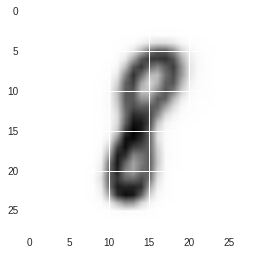

pixel mean 0.131421
8


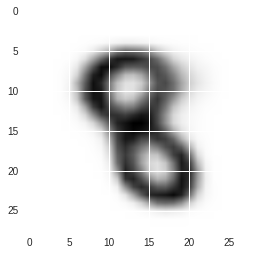

pixel mean 0.130771
8


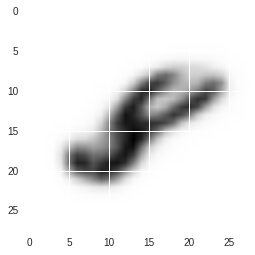

pixel mean 0.126957
8


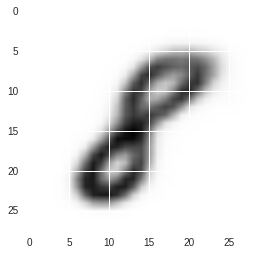

pixel mean 0.131731
8


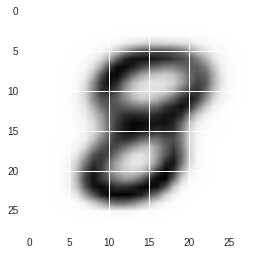

pixel mean 0.125568
8


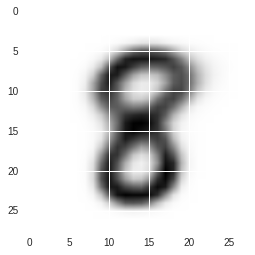

pixel mean 0.121746
8


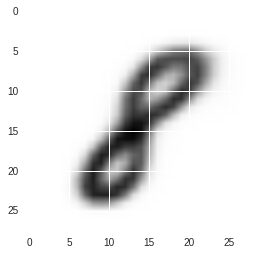

pixel mean 0.130613
8


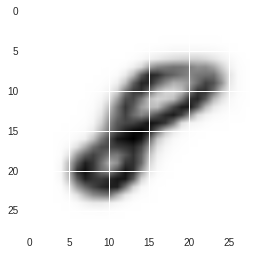

pixel mean 0.125844
9


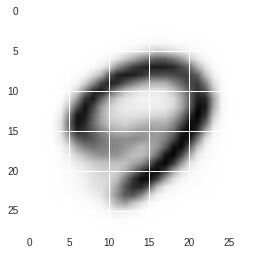

pixel mean 0.124545
9


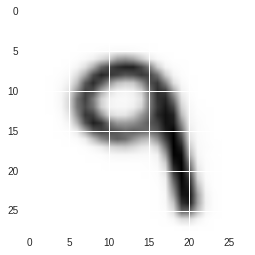

pixel mean 0.122884
9


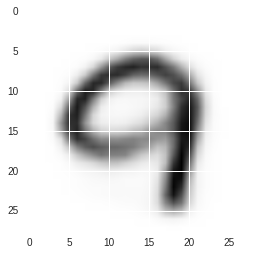

pixel mean 0.129718
9


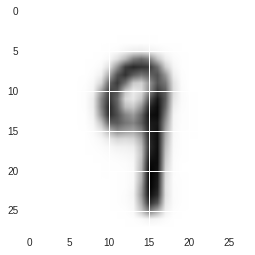

pixel mean 0.13609
9


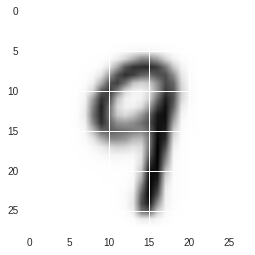

pixel mean 0.135185
9


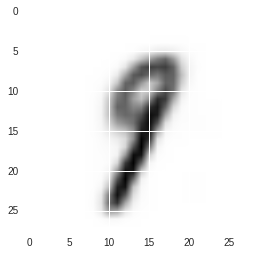

pixel mean 0.139432
9


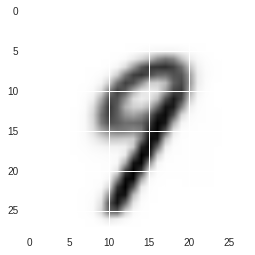

pixel mean 0.125991
9


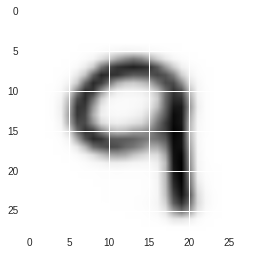

pixel mean 0.130669
9


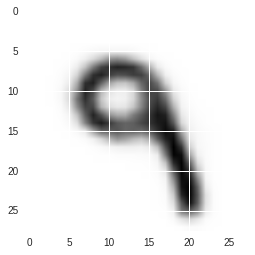

pixel mean 0.124912
9


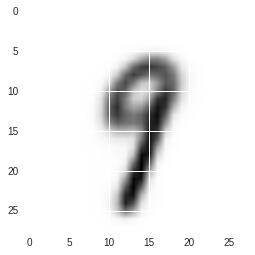

In [12]:
for i in range(10):
    for _ in range(10):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        print "pixel mean", np.mean(batch_xs)
        batch_xs = batch_xs.reshape([-1, image_width, image_width, 1])
    #     plt.imshow(np.mean(batch_xs, axis=0)[:,:,0])
    #     plt.show()
    # np.mean(batch_xs, axis=0)[:,:,0]
        batch_xs = np.abs(np.random.normal(loc=np.mean(batch_xs), scale=.02, size=batch_xs.shape))#np.ones_like(batch_xs)*np.mean(batch_xs)
        batch_ys = np.zeros_like(batch_ys)
        batch_ys[:, i]=1
#         batch_ys[:, i+1]=1




        gen, mu_pred, sig_pred = vae.sess.run([vae.x_reconstr_mean, 
                                        vae.z_mean, vae.z_log_sigma_sq], feed_dict = 
                                       {vae.x:batch_xs, vae.y:batch_ys})
        gen = vae.sess.run(vae.x_reconstr_mean, feed_dict = 
                                       {vae.y:batch_ys, 
                                        vae.z_mean: np.zeros_like(mu_pred), vae.z_log_sigma_sq:np.ones_like(sig_pred)})
    
        gen = gen.reshape([-1, image_width, image_width, 1])


    #     print plt.scatter(label_pred[0], batch_ys[0]) 
        plt.show()
        print np.argmax(batch_ys[0])

        gen = np.reshape(gen,[-1,image_width, image_width])
        plt.imshow(gen[0])
        plt.show()
    #     plt.imshow(batch_xs[0,:,:,0])
    #     plt.colorbar()
    #     plt.show()
    


pixel mean 0.129256
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


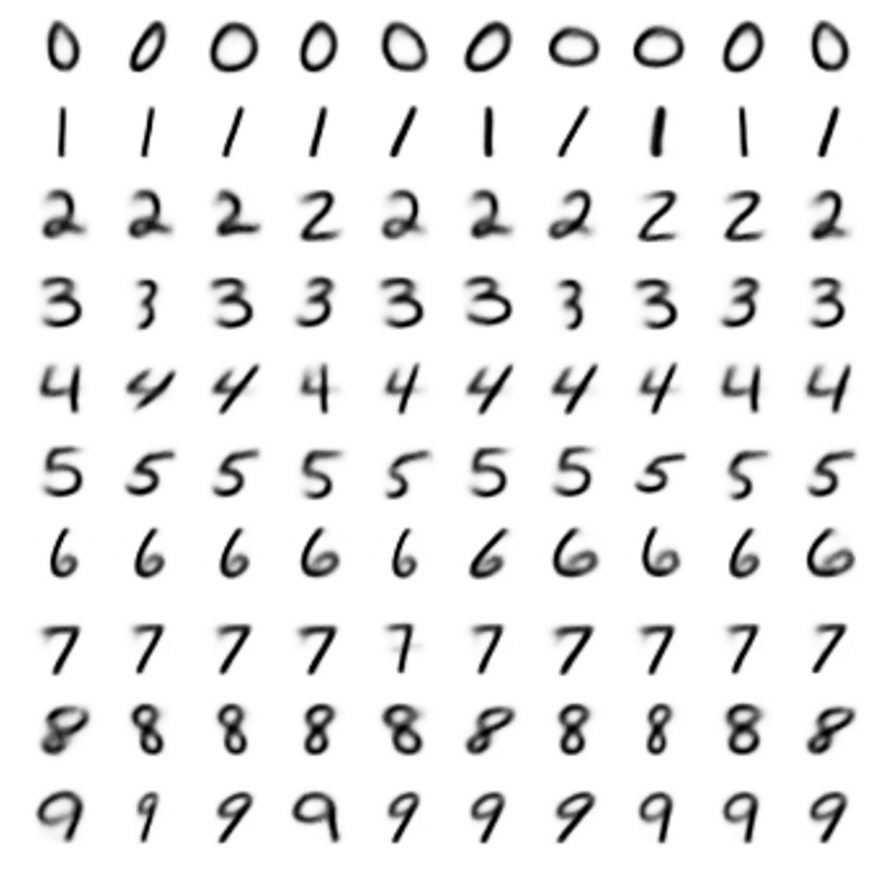

In [13]:
batch_xs, batch_ys = mnist.train.next_batch(100)
print "pixel mean", np.mean(batch_xs)
batch_xs = batch_xs.reshape([-1, image_width, image_width, 1])
batch_ys = np.zeros_like(batch_ys)
batch_ys[:, 0]=1
plt.figure(figsize=(15, 15))

rows = 8
f, axarr = plt.subplots(10, 10)

f.set_figheight(15)
f.set_figwidth(15)

batch_ys = np.zeros_like(batch_ys)
mu_fed = np.zeros_like(mu_pred)
random1 = np.random.normal(size=vae.network_architecture["n_z"])
random1 /= np.sqrt(np.sum(np.square(random1)))
# random1 = np.zeros_like(random1)
# random1[6]=1
for i in range(100):
        batch_ys[i, i/10]=1
#         mu_fed[i] += random1*(i%10-5)*5
print mu_fed
x_sample = vae.sess.run(vae.x_reconstr_mean, feed_dict = 
                {vae.y:batch_ys, 
                vae.z_mean: mu_fed, 
                 vae.z_log_sigma_sq:np.zeros_like(sig_pred)})
x_sample = x_sample.reshape(-1, image_width, image_width)
for i in range(10):
    for j in range(10):
        
        axarr[i,j].imshow(x_sample[i*10+j,:,:], interpolation="catrom")
        axarr[i,j].axis('off')
        
        



Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

(100, 784)


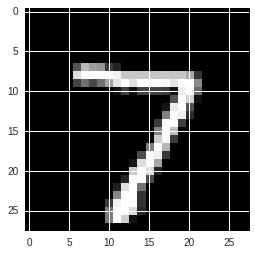

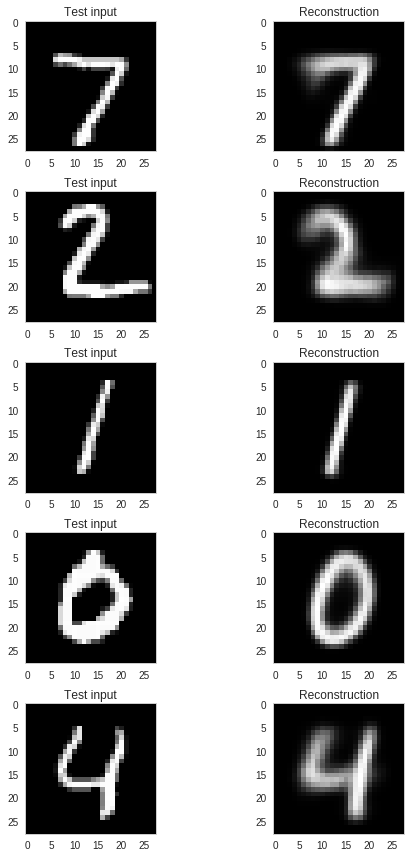

In [14]:
image_width = 28
# x_sample = get_batch(100)[0]#mnist.test.next_batch(100)[0]
x_sample, y_sample = mnist.test.next_batch(100)

plt.imshow(x_sample[0].reshape(image_width, image_width), cmap='gray', interpolation = 'nearest')
print x_sample.shape
x_sample = x_sample.reshape([-1, image_width, image_width, 1])
x_reconstruct = vae.reconstruct(x_sample, y_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    sns.set_style("whitegrid", {'axes.grid' : False})

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(image_width, image_width), cmap='gray', interpolation = 'nearest')
    plt.title("Test input")
#     plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(image_width, image_width), cmap='gray', interpolation = 'nearest')
    plt.title("Reconstruction")
#     plt.colorbar()
plt.tight_layout()

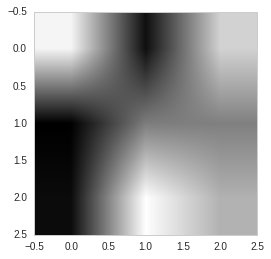

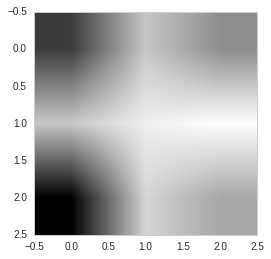

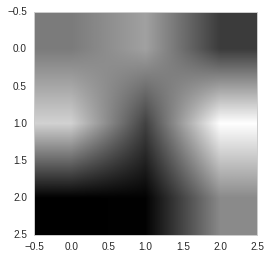

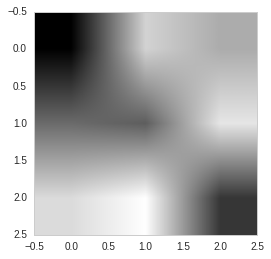

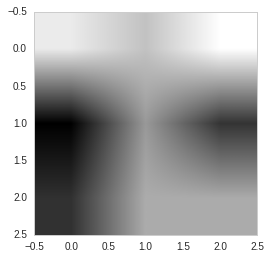

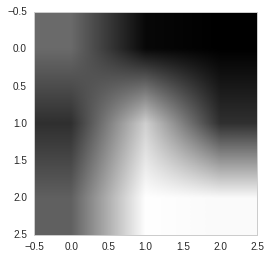

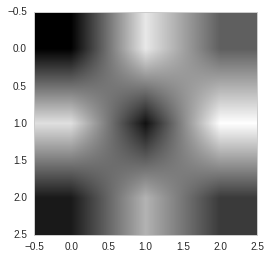

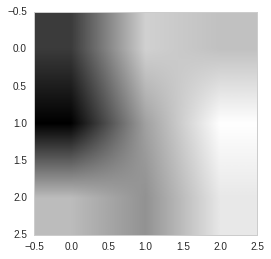

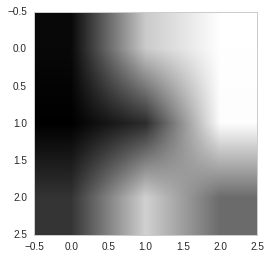

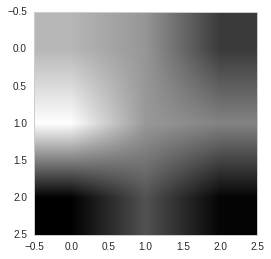

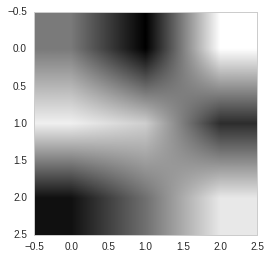

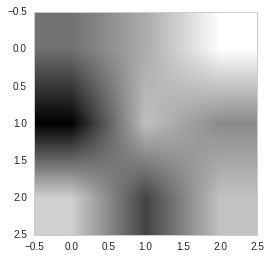

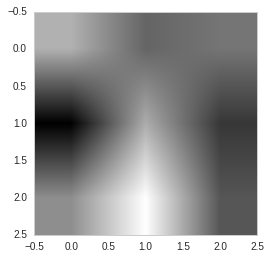

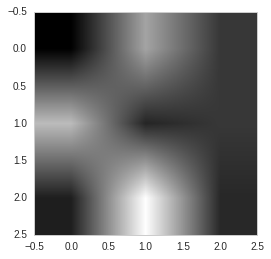

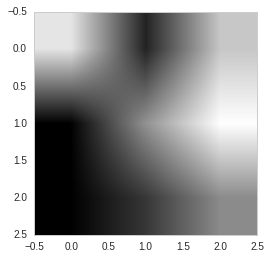

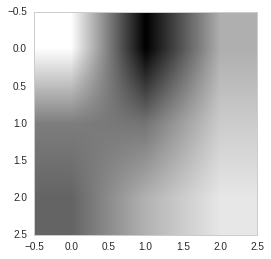

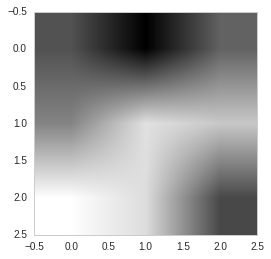

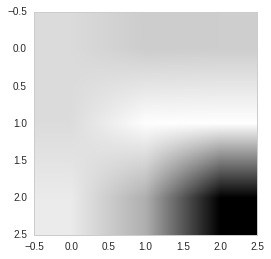

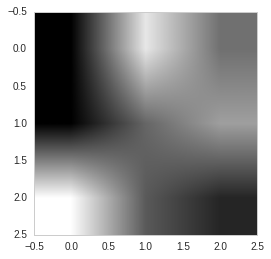

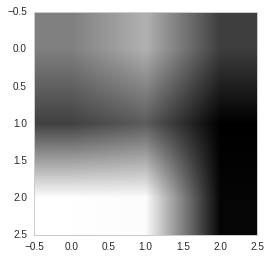

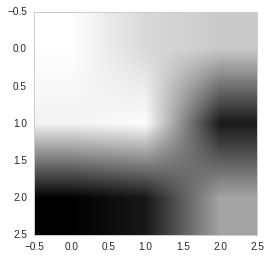

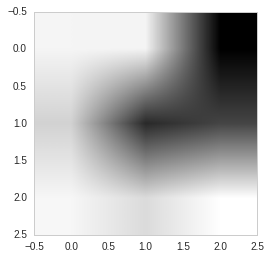

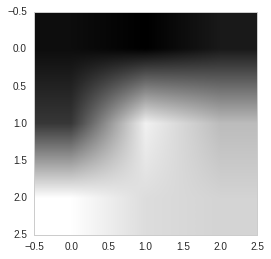

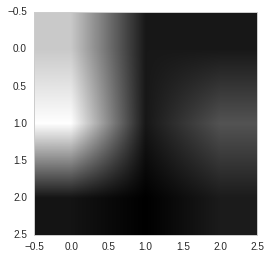

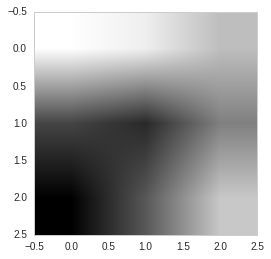

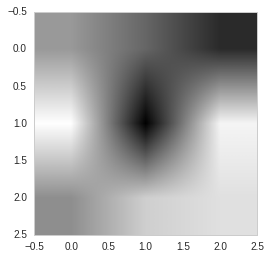

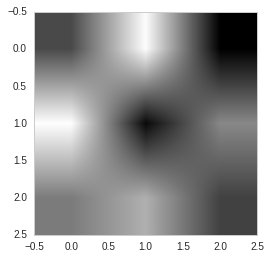

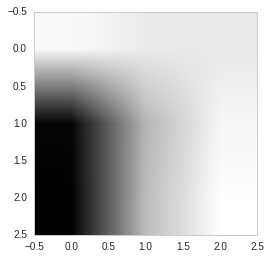

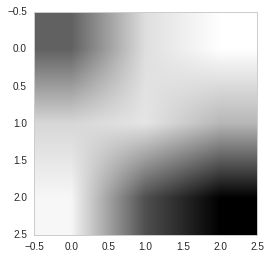

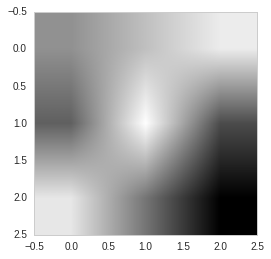

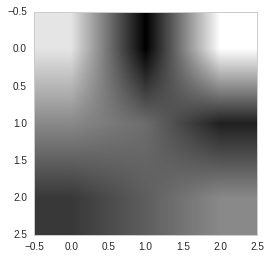

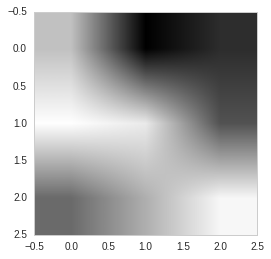

In [15]:
weights = bottom_conv_weights.eval(vae.sess)
for i in range(weights.shape[-1]):
    plt.imshow(weights[:,:,0,i])
    plt.show()

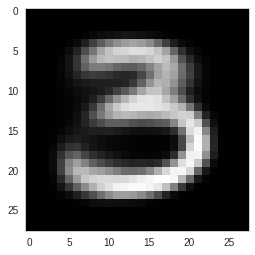

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interactive
import IPython.html.widgets as widgets
from IPython.display import display
x_sample = np.reshape(mnist.test.next_batch(100)[0], [-1,28,28,1])
_, batch_ys = mnist.train.next_batch(batch_size)
y_sample = np.zeros_like(batch_ys)
y_sample[:, 3]=1
# x_sample = mnist.test.next_batch(100)[0]
# x_sample = get_batch(10)[0]
start = vae.transform(x_sample, y_sample)[0]
# start = np.random.normal(size=vae.network_architecture["n_z"])
print start.shape
n_z = vae.network_architecture["n_z"]

# random1 = np.zeros(vae.network_architecture["n_z"])#np.random.normal(size=vae.network_architecture["n_z"])
# random1[1]=1
# random2 = np.zeros(vae.network_architecture["n_z"])#np.random.normal(size=vae.network_architecture["n_z"])
# random2[3]=1
random1 = np.random.normal(size=vae.network_architecture["n_z"])
random1 /= np.sqrt(np.sum(np.square(random1)))

random2 = np.random.normal(size=vae.network_architecture["n_z"])
random2 /= np.sqrt(np.sum(np.square(random2)))

image = vae.generate(None, y_sample)[0]
image = np.reshape(image,[image_width,image_width])
# plt.imshow(image)

# image = vae.generate(z_mu=random1)[0]

# image = vae.generate(z_mu=start + random1 + random2)[0]

def latentwalk(a=0.0,b=0.0, dimension_select = 0, dimension_slide = 0):
#     IPython.display.clear_output(wait=True)
#     IPython.display.display(plt.gcf())
    dim = np.zeros(n_z)
    dim[dimension_select] = 1.0
    image = vae.generate(np.array([start + random1*a + random2*b + dim*dimension_slide]*vae.batch_size), y_sample)[0]

#     global image
    plt.imshow(np.reshape(image, [28,28]), cmap='gray', interpolation = 'nearest')

#     print image.shape

    image = np.reshape(image,[image_width,image_width])
    plt.imshow(image, cmap='gray', interpolation = 'nearest')
    plt.gcf().show()
#     plt.show()




a_slide = widgets.FloatSlider(min=-10,max=10, step=0.03, value=0)
b_slide = widgets.FloatSlider(min=-10,max=10, step=0.03, value=0)
dimension_slide = widgets.FloatSlider(min=-10,max=10, step=0.03, value=0)
dimension_select = widgets.IntSlider(min=0,max=n_z-1, step=0.03, value=0)

w=widgets.interactive(latentwalk,a=a_slide,b=b_slide, dimension_select=dimension_select, dimension_slide = dimension_slide)
display(w)


In [ ]:
mnist.test.next_batch(100)[1].shape

In [ ]:
from scipy.stats import multivariate_normal
# x = np.array(np.linspace(0, 5, 190, endpoint=False),np.linspace(0, 5, 190, endpoint=False))
nx=40
ny=40
x = np.linspace(-1, 1
                , nx)
y = np.linspace(-1, 1, ny)
xx, yy = np.meshgrid(x, y)
# print xx
# print xv.shape

zz = np.zeros(xx.shape)
normal = np.zeros(xx.shape)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        for k in range(Mu.shape[0]):
            zz[i,j] += multivariate_normal.pdf([xx[i,j],yy[i,j]], mean=Mu[k], cov=Sigma[k])
        normal[i,j] += multivariate_normal.pdf([xx[i,j],yy[i,j]], mean=Mu[0], cov=Sigma[0])

# plot the calculated function values
# pylab.pcolor(xx,yy,zz)

# # and a color bar to show the correspondence between function value and color
# pylab.colorbar()

# pylab.show() 
plt.imshow((zz))
plt.show()

plt.imshow(normal)
plt.show()

# y = multivariate_normal.pdf([0,0], mean=Mu[0], cov=Sigma[0])


# plt.plot(x, y)

In [ ]:
print vae.z_mean.get_shape()
batch_xs = np.reshape(mnist.train.next_batch(52)[0], [-1, image_width, image_width,1])
Mu, Sigma = vae.get_distributions(batch_xs)
print Mu
print Sigma

print Mu.shape
print Sigma.shape
# def probability_density(x,y):
    

In [ ]:
from sklearn.manifold import TSNE
data = None
all_sigmas =  None
y_data = batch_ys
for i in range(30):
    f.value = i
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.reshape([-1, image_width, image_width, 1])
    new_m, new_s, m_, s_, gen_correct = vae.sess.run([vae.z_mean_pred, vae.z_log_sig_sq_pred, vae.z_mean, vae.z_log_sigma_sq, vae.x_reconstr_mean],
                                      feed_dict = {vae.x:batch_xs, vae.y:batch_ys})
    if data == None:
        data = new_m
    else:
        data = np.append(data, new_m, axis=0)
    if all_sigmas == None:
        all_sigmas= new_s
    else:
        all_sigmas = np.append(all_sigmas, new_s, axis=0)


    y_data = np.append(y_data, batch_ys, axis=0)

y_data=np.argmax(y_data, axis=1)

In [ ]:
# tsne = TSNE(perplexity=.001, n_components=2, init='pca', n_iter=5000)
# print data.shape
# lowDWeights = tsne.fit_transform(data)
# print y_data.shape
# for i in range(10):
#     plt.scatter(lowDWeights[y_data==i,0],lowDWeights[y_data==i,1], cmap = "viridis")
#     plt.show()
plt.scatter(lowDWeights[:,0] + np.random.normal(size=3000)*.5,lowDWeights[:,1] + np.random.normal(size=3000)*.5)
# plt.colorbar()
plt.show()

In [ ]:
np.random.normal(size=10100)

In [ ]:
z_mu_three = np.mean(data[y_data==3,:], axis=0)
z_sigma_three = np.mean(all_sigmas[y_data==3,:], axis=0)

In [ ]:
z_three